### imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input, Concatenate, GlobalAveragePooling2D, Reshape, Dense, Multiply, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
import os
import cv2
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.utils import plot_model
import config
import json
import numpy as np
import optuna
from segmentation_models.metrics import iou_score, IOUScore, FScore
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback
from tensorflow.keras.regularizers import l1, l2
from math import ceil

# TF CONFIGURATION
print("Número de GPUs disponíveis: ", len(
    tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU') #força usar a 0
        tf.config.experimental.set_memory_growth(gpus[0], True) #so usa memoria a medida q precisa
    except RuntimeError as e:
        print(e)

2024-02-27 17:43:05.823938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 17:43:05.933207: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 17:43:06.436449: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-02-27 17:43:06.436494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Segmentation Models: using `keras` framework.
Número de GPUs disponíveis:  2
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


/home/arthur_guilherme/.conda/envs/mackele_a/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-02-27 17:43:07.447323: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-27 17:43:07.448002: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-27 17:43:07.454288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-27 17:43:07.454984: I tensorflow/stream_executor/cuda

### dataset -> (leitura - pré_processamento - generator)

In [3]:
#TRAIN - caminho das pastas
train_images_path = "Dataset/train/Images_Cropped"
train_masks_path = "Dataset/train/Masks_Cropped"
#VAL
val_images_path = "Dataset/val/Images_Cropped"
val_masks_path = "Dataset/val/Masks_Cropped"
#TEST
test_images_path = "Dataset/test/Images_Cropped"
test_masks_path = "Dataset/test/Masks_Cropped"

#TRAIN - lista com todos os nomes dos arquivos de imagem
train_images_list = os.listdir(train_images_path)
train_masks_list = os.listdir(train_masks_path)
#VAL
val_images_list = os.listdir(val_images_path)
val_masks_list = os.listdir(val_masks_path)
#TEST
test_images_list = os.listdir(test_images_path)
test_masks_list = os.listdir(test_masks_path)

#TRAIN - ordenação dos nomes dos arquivos
train_images_list.sort()
train_masks_list.sort()
#VAL
val_images_list.sort()
val_masks_list.sort()
#VAL
test_images_list.sort()
test_masks_list.sort()

In [4]:
def image_mask_generator(images_list, images_path, masks_path, batch_size= config.BATCH_SIZE, output_size=config.IMAGE_SIZE):
    num_samples = len(images_list)
    while True:
        # Embaralhar os índices para garantir que os dados sejam apresentados de forma aleatória
        indices = np.random.permutation(num_samples)
        for i in range(0, num_samples, batch_size):
            batch_indices = indices[i:i+batch_size]
            batch_images = []
            
            batch_masks = []
            for idx in batch_indices:
                img_filename = os.path.join(images_path, images_list[idx])
                mask_filename = os.path.join(masks_path, images_list[idx][:-4] + ".png")

                if not os.path.isfile(img_filename) or not os.path.isfile(mask_filename):
                    print(f"Arquivo de imagem ou máscara não encontrado: {images_list[idx]}")
                    continue

                img = cv2.imread(img_filename)
                mask = cv2.imread(mask_filename, cv2.IMREAD_UNCHANGED) #cv2.IMREAD_GRAYSCALE
                
                if img is None or mask is None:
                    print(f"Falha ao carregar imagem ou máscara: {images_list[idx]}")
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, output_size)
                mask = cv2.resize(mask, output_size, interpolation=cv2.INTER_NEAREST)
                
                img = img.astype(np.float32) / 255.0
                mask = tf.one_hot(mask, 3)

                batch_images.append(img)
                batch_masks.append(mask)

            yield np.array(batch_images), np.array(batch_masks)

In [5]:
#TRAIN
gerador_treino = image_mask_generator(train_images_list, train_images_path, train_masks_path)
#VAL
gerador_validacao = image_mask_generator(val_images_list, val_images_path, val_masks_path)
#TEST
gerador_teste = image_mask_generator(test_images_list, test_images_path, test_masks_path, batch_size=1)

### construção do modelo Unet, com backbone EfficientNet e blocos Squeeze-Excitation

In [2]:
""" Função Squeeze Excitation """

# def SqueezeAndExcitation(inputs, ratio=8):
#     b, h, w, c = inputs.shape

#     ## Squeeze
#     x = GlobalAveragePooling2D()(inputs)

#     ## Excitation
#     x = Dense(c//ratio, activation='relu', use_bias=False, kernel_regularizer=l2(0.01))(x)
#     x = Dense(c, activation='sigmoid', use_bias=False, kernel_regularizer=l2(0.01))(x)

#     ## Ensure x has dimensions (batch_size, 1, 1, channels)
#     x = tf.expand_dims(x, axis=1)
#     x = tf.expand_dims(x, axis=1)

#     ## Scaling
#     x = inputs * x

#     return x


def conv_block(inputs, num_filters, dropout_rate=0.0):
    x = Conv2D(num_filters, 3, padding='same')(inputs)#, kernel_regularizer=l2(0.01)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)

    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if dropout_rate > 0.0:
        x = Dropout(dropout_rate)(x)

    return x


def decoder_block(inputs, skip, num_filters, dropout_rate=0.0):
    x = Conv2DTranspose(num_filters, (2,2), strides=2, padding='same')(inputs)
    # x = SqueezeAndExcitation(x)
    x = Concatenate()([x, skip])
    x = conv_block(x, num_filters, dropout_rate=dropout_rate)
    return x

def build_efficient_unet(input_shape, dropout_rate=0.0):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained Encoder """
    encoder = EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    # encoder.summary()

    s1 = encoder.layers[0].output                          ## 256
    s2 = encoder.layers[20].output        ## 128
    s3 = encoder.layers[49].output        ## 64
    s4 = encoder.layers[78].output        ## 32

    """ Bottleneck """
    b1 = encoder.layers[165].output        ## 16

    """ Decoder """
    d1 = decoder_block(b1, s4, 512, dropout_rate=dropout_rate)                                    ## 32
    d2 = decoder_block(d1, s3, 256, dropout_rate=dropout_rate)                                ## 64
    d3 = decoder_block(d2, s2, 128, dropout_rate=dropout_rate)                                    ## 128
    d4 = decoder_block(d3, s1, 64, dropout_rate=dropout_rate)                                     ## 265

    """ Output """
    outputs = Conv2D(3, 1, padding="same", activation='softmax')(d4)

    model = Model(inputs, outputs, name="EfficientNetB0_UNET")
    
    return model


In [3]:
modelo = build_efficient_unet(input_shape=(224,224,3), dropout_rate=0.5)

metrics = [IOUScore(class_indexes=1, threshold=0.5, name='iou_disco'), IOUScore(class_indexes=2, threshold=0.5, name='iou_cup'), FScore(class_indexes=1, threshold=0.5, name='dice_disco'), FScore(class_indexes=2, threshold=0.5, name='dice_cup')]


modelo.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= config.LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics= metrics)
# modelo.summary()

2024-02-27 17:43:13.748281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 17:43:13.748683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-27 17:43:13.749405: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-27 17:43:13.749925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

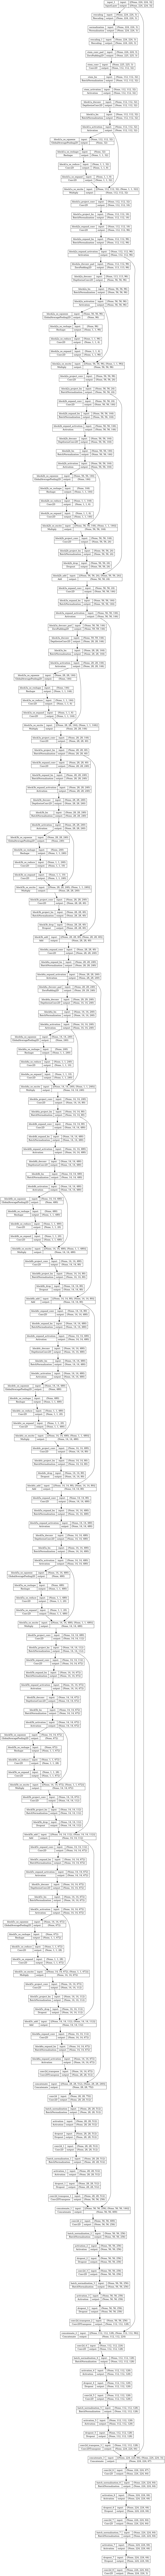

In [4]:
tf.keras.utils.plot_model(modelo, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [12]:
# pretrain model decoder
callbacks_list = [EarlyStopping(monitor = 'val_iou_cup', patience = 25, mode = 'auto', verbose = 1),
                ModelCheckpoint(f"/home/arthur_guilherme/pibic_mack-24/segmentation_refuge/checkpoint/best_model_weights.h5", monitor = 'val_iou_cup', verbose = 1, save_best_only = True,save_weights_only = True, mode= 'max', initial_value_threshold=0.7)]


history = modelo.fit(gerador_treino, 
           validation_data = gerador_validacao,
           epochs= config.EPOCHS,
           callbacks = callbacks_list,
           steps_per_epoch= ceil(len(train_images_list)/config.BATCH_SIZE),
           validation_steps= ceil(len(val_images_list)/config.BATCH_SIZE),
           verbose=1)

Epoch 1/100


2024-02-27 17:19:52.350140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700
2024-02-27 17:19:52.719461: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


50/50 [==============================] - ETA: 0s - loss: 0.4428 - iou_disco: 0.7312 - iou_cup: 0.5486 - dice_disco: 0.8388 - dice_cup: 0.6734
Epoch 1: val_iou_cup did not improve from 0.70000
50/50 [==============================] - 19s 242ms/step - loss: 0.4428 - iou_disco: 0.7312 - iou_cup: 0.5486 - dice_disco: 0.8388 - dice_cup: 0.6734 - val_loss: 369.0961 - val_iou_disco: 4.9772e-11 - val_iou_cup: 0.2311 - val_dice_disco: 4.9772e-11 - val_dice_cup: 0.3746
Epoch 2/100
50/50 [==============================] - ETA: 0s - loss: 0.2360 - iou_disco: 0.8382 - iou_cup: 0.7635 - dice_disco: 0.9118 - dice_cup: 0.8655
Epoch 2: val_iou_cup did not improve from 0.70000
50/50 [==============================] - 11s 224ms/step - loss: 0.2360 - iou_disco: 0.8382 - iou_cup: 0.7635 - dice_disco: 0.9118 - dice_cup: 0.8655 - val_loss: 43.3990 - val_iou_disco: 0.0131 - val_iou_cup: 0.2120 - val_dice_disco: 0.0259 - val_dice_cup: 0.3490
Epoch 3/100
50/50 [==============================] - ETA: 0s - loss: 